## 0.依赖模块导入

In [1]:
import xlrd
import os
import time
import warnings
import numpy as np
import time
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.utils import plot_model
from keras.models import load_model

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

Using TensorFlow backend.


## 1.数据预处理
1. 数据标准化
2. 数据读入处理
3. 数据导入

#### 数据标准化
公式：
$$ n_i = \frac{p_i}{p_0} - 1 $$

$ n_i $ 为处理后数据

$ p_i $ 为处理前数据

$ p_0 $ 为处理窗口的第一个数据

In [2]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [[((float(d) / float(window[0][i])) - 1) for i, d in enumerate(p)] for p in window]
        normalised_data.append(normalised_window)
    return normalised_data


#### 数据读入处理

In [3]:
def read_data(name, sequence_length):
    table = xlrd.open_workbook(name).sheets()[0]
    data = [table.row_values(i)[1:] for i in range(1, table.nrows)][::-1]  # 倒序处理
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    result = normalise_windows(result)
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1, :]
    y_train = train[:, -1, 3]
    x_test = result[int(row):, :-1, :]
    y_test = result[int(row):, -1, 3]
    return [x_train, y_train, x_test, y_test]

#### 数据导入

In [4]:
data_path = '.\data\上证综指.xlsx'
sequence = 50
x_train, y_train, x_test, y_test = read_data(data_path, sequence)

In [62]:
print(x_train.shape, y_train.shape)

(2145, 49, 5) (2145,)


## 2.模型构建
1. 建立模型
2. 训练
3. 绘制相关结果

#### 建立模型
两层LSTM结构

Layers为各层的维度:
* Layers[0]:为输入维度
* Layers[1]:第一层LSTM输出维度
* Layers[2]:第二层LSTM输出维度
* Layers[3]:全连接层输出维度

准确度计算公式：
$$ acc = 1 - |\frac{y_t - y_p}{y_t + 1}| $$

In [5]:
import tensorflow as tf
def accuracy(y_true, y_pred):
    temp = tf.abs(tf.div(tf.subtract(y_true, y_pred), tf.add(y_true, 1)))
    return tf.reduce_mean(tf.subtract(tf.cast(1, tf.float32), temp))
                       

In [6]:
def build_model(layers, dropout=0.2):
    model = Sequential()

    model.add(LSTM(input_dim=layers[0], output_dim=layers[1], return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(layers[2], return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=[accuracy])
    return model

#### 模型训练

In [31]:
epochs = 500
model = build_model([5, 50, 100, 1])
log = model.fit(x_train, y_train, batch_size=512, nb_epoch=epochs, validation_split=0.05)

Train on 2037 samples, validate on 108 samples
Epoch 1/500
2037/2037 [==============================] - 4s - loss: 0.0135 - accuracy: 0.9160 - val_loss: 0.0033 - val_accuracy: 0.9549
Epoch 2/500
2037/2037 [==============================] - 2s - loss: 0.0033 - accuracy: 0.9574 - val_loss: 0.0018 - val_accuracy: 0.9652
Epoch 3/500
2037/2037 [==============================] - 2s - loss: 0.0022 - accuracy: 0.9649 - val_loss: 0.0016 - val_accuracy: 0.9675

In [32]:
model.save('my_model.h5')

In [7]:
%matplotlib inline

#### 绘制结果

In [34]:
def plot_metric(name, data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(data, label='True Data')
    plt.title(name)
    plt.show()

训练集损失

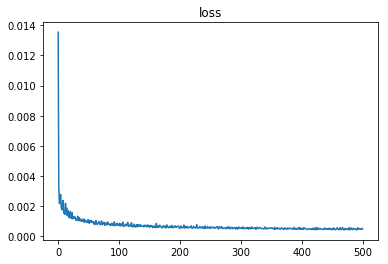

In [35]:
plot_metric('loss', log.history['loss'])

验证集准确度

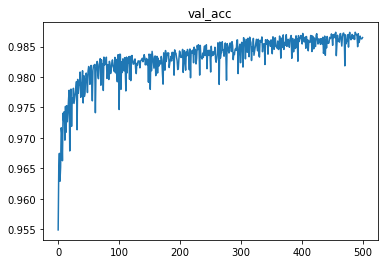

In [36]:
plot_metric('val_acc', log.history['val_accuracy'])

## 3.模型测试

In [7]:
model = load_model('my_model.h5')  # 导入训练好的模型
# plot_model(model, to_file='model.png')

In [61]:
predict = model.predict(x_test)
predict = np.reshape(predict, (predict.size,))

In [68]:
def analysis(pred_data, true_data, model=1):
    error = []
    metric_dict = {0.01:0, 0.02:0, 0.05:0, 'updown':0}
    n = len(true_data)
    for i in range(n):
        t = abs(pred_data[i] - true_data[i])/(true_data[i]+1)
        if t<0.05:
            metric_dict[0.05] += 1
            if t<0.02:
                metric_dict[0.02] += 1
                if t<0.01:
                    metric_dict[0.01] += 1
        error.append(t)
    if model == 1:
        print('误差0.01以内:{:.4f}%'.format(metric_dict[0.01]*100/n))
        print('误差0.02以内:{:.4f}%'.format(metric_dict[0.02]*100/n))
        print('误差0.05以内:{:.4f}%'.format(metric_dict[0.05]*100/n))
        return error
    else:
        return {k:metric_dict[k]*100/n for k in  metric_dict}

测试集拟合效果图

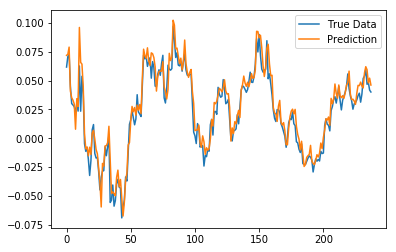

In [12]:
nf = plt.figure(facecolor='white')
plt.plot(y_test, label='True Data')
plt.plot(predict, label='Prediction')
plt.legend()
plt.show()

In [69]:
error = analysis(predict, y_test)

误差0.01以内:81.5126%
误差0.02以内:96.2185%
误差0.05以内:100.0000%


误差统计直方图

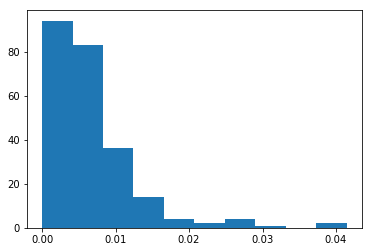

In [82]:
plt.figure(facecolor='white')
plt.hist(error, normed=True)
plt.show()

误差折线图

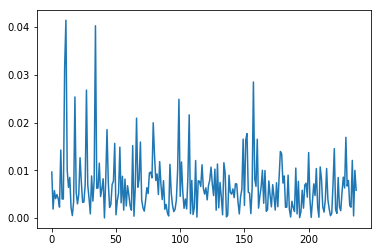

In [83]:
plt.figure(facecolor='white')
plt.plot(error, label='accuracy')
plt.show()

## 4.模型应用
   通过上面的模型测试可以看出，模型已经可以通过对股票过往交易的开盘价、最高价、最低价、收盘价、成交量分析对第二天的价格做出一定得的预测，下面将该模型应用于个股的分析。

#### 股票数据处理

In [58]:
def handle_stack(stack, sequence_length):
    data = stack[::-1]
    data = [d[1:5]+[''.join(d[7].split(','))] for d in data]
    #print(data)
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    result = normalise_windows(result)
    result = np.array(result)
    x = result[:, :-1, :]
    y = result[:, -1, 3]
    # print(x.shape,y.shape)
    return x,y

#### 股票抓取

In [10]:
import requests
from bs4 import BeautifulSoup

In [8]:
def stack_grab(stack_id, holder, date=None, quantity=100):
    result = []
    date_dict = {'01':1, '02':1, '03':1, '04':2, '05':2, '06':2, '07':3, '08':3, '10':4}
    url = 'http://quotes.money.163.com/trade/lsjysj_%d.html' % stack_id
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:22.0) Gecko/20100101 Firefox/22.0'}
    if date == None:
        response = requests.get(url, headers=headers)
    else:
        response = requests.get(url, headers=headers,params=date)
    soup = BeautifulSoup(response.text, 'lxml')
    deal_list = soup.find_all('tr')
    for deal in deal_list:
        if len(deal.contents) == 11:
            result.append([tag.string for tag in deal.contents])
            quantity -= 1
            if quantity == 0:
                break
    if holder.get(stack_id) == None:
        holder[stack_id] = result
    else:
        holder[stack_id].extend(result)
        
    if quantity and result:  # 当数量达标或无记录可爬时停止
        if date == None:
            first_deal_date = result[-1][0].split('-')
            date = {'year':first_deal_date[0], 'season':date_dict[first_deal_date[1]]}
        if date['season'] == 1:
            new_date = {'year':str(int(date['year'])-1), 'season':4}
        else:
            new_date = {'year':date['year'], 'season':date['season']-1}
        stack_grab(stack_id, holder, new_date, quantity)  # 递归爬取



In [11]:
h = {}
import random
# 随机抓取50支股票
for i in range(50):
    s_id = 600000 + random.randint(0,600)
    print(s_id, i)
    stack_grab(s_id, h)

600056 0
600280 1
600436 2
600313 3
600361 4
600360 5
600218 6
600579 7
600120 8
600314 9
600342 10
600185 11
600014 12
600031 13
600348 14
600513 15
600388 16
600075 17
600321 18
600438 19
600085 20
600365 21
600240 22
600265 23
600141 24
600398 25
600351 26
600017 27
600267 28
600442 29
600272 30
600498 31
600344 32
600124 33
600099 34
600193 35
600329 36
600118 37
600461 38
600427 39
600491 40
600121 41
600120 42
600235 43
600442 44
600143 45
600539 46
600214 47
600231 48
600466 49


In [59]:
stack_acc_dict = {}
for k in h:
    if len(h[k]) == 100:  # 剔除不存在和数量不够的股票
        s_x,s_y = handle_stack(h[k], 50)
        predict = model.predict(s_x)
        predict = np.reshape(predict, (predict.size,))
        stack_acc_dict[k] = analysis(predict, s_y, model=2)

#### 个股预测结果

In [60]:
s_dict = {}
for i in sorted(stack_acc_dict,key=lambda s:stack_acc_dict[s][0.01],reverse=True):
    print('股票代码:%d  误差0.01以内:%.1f%%  误差0.02以内:%.1f%%  误差0.05以内:%.1f%%'
        % (i,stack_acc_dict[i][0.01],stack_acc_dict[i][0.02],stack_acc_dict[i][0.05]))

股票代码:600329  误差0.01以内:58.0%  误差0.02以内:70.0%  误差0.05以内:100.0%
股票代码:600031  误差0.01以内:58.0%  误差0.02以内:78.0%  误差0.05以内:98.0%
股票代码:600085  误差0.01以内:56.0%  误差0.02以内:84.0%  误差0.05以内:100.0%
股票代码:600438  误差0.01以内:54.0%  误差0.02以内:74.0%  误差0.05以内:92.0%
股票代码:600218  误差0.01以内:52.0%  误差0.02以内:76.0%  误差0.05以内:98.0%
股票代码:600461  误差0.01以内:50.0%  误差0.02以内:76.0%  误差0.05以内:100.0%
股票代码:600280  误差0.01以内:50.0%  误差0.02以内:68.0%  误差0.05以内:100.0%
股票代码:600231  误差0.01以内:50.0%  误差0.02以内:70.0%  误差0.05以内:96.0%
股票代码:600240  误差0.01以内:48.0%  误差0.02以内:70.0%  误差0.05以内:96.0%
股票代码:600056  误差0.01以内:48.0%  误差0.02以内:78.0%  误差0.05以内:100.0%
股票代码:600436  误差0.01以内:46.0%  误差0.02以内:64.0%  误差0.05以内:98.0%
股票代码:600498  误差0.01以内:44.0%  误差0.02以内:72.0%  误差0.05以内:98.0%
股票代码:600265  误差0.01以内:44.0%  误差0.02以内:68.0%  误差0.05以内:88.0%
股票代码:600141  误差0.01以内:42.0%  误差0.02以内:72.0%  误差0.05以内:100.0%
股票代码:600267  误差0.01以内:42.0%  误差0.02以内:74.0%  误差0.05以内:100.0%
股票代码:600360  误差0.01以内:42.0%  误差0.02以内:72.0%  误差0.05以内:94.0%
股票代码:600121  误差0.01以内:42.0%  误差0.

#### 结果分析
   在个股上模型的准确率有所下降，而且层次不齐，这是因为，个股更容易被操纵，被政策影响。但不难发现，模型在一些股票上的准确率还是可以接受的，因为这些股票比较稳定。